# 🧠 Glass Box Stroke Classifier — Demo Notebook

**Goal:** Train the calibrated stacked ensemble, evaluate it on the test split, then generate **SHAP (surrogate glass-box)** and **LIME (local)** explanations.

**Dataset:** Kaggle Stroke Prediction Dataset (`data/raw/stroke.csv`).

> Tip: This notebook is designed to work with the structured repo (`src/`, `configs/`). If you cloned the repo, run this notebook from the repo root.


## 1) Setup
This imports project modules and checks that paths exist.

In [19]:
from pathlib import Path
import os

def cd_to_repo_root(marker="configs/default.yaml", max_up=8):
    """
    Walk up parent directories until we find the repo root
    (identified by presence of configs/default.yaml).
    """
    p = Path.cwd()
    for _ in range(max_up):
        if (p / marker).exists():
            os.chdir(p)
            return p
        p = p.parent
    raise FileNotFoundError(f"Could not find repo root containing '{marker}'")

root = cd_to_repo_root()
print("✅ Working directory set to repo root:")
print(Path.cwd())

# Sanity check
print("\nconfigs exists:", Path("configs/default.yaml").exists())
print("data/raw exists:", Path("data/raw/stroke.csv").exists())

✅ Working directory set to repo root:
e:\Code Playground\ML-Projects\The-Glass-Box-Healthcare-Classifier

configs exists: True
data/raw exists: True


## 2) Load Config + Dataset
We read the YAML config and load the CSV.

In [20]:
import yaml
import pandas as pd

CONFIG_PATH = "configs/default.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

DATA_PATH = cfg["data"]["path"]
TARGET = cfg["data"]["target"]
ID_COL = cfg["data"].get("id_column", None)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Drop ID column if configured
if ID_COL and ID_COL in df.columns:
    df = df.drop(columns=[ID_COL])

print("\nTarget distribution:")
print(df[TARGET].value_counts())
print("\nMissing values (top):")
print(df.isna().sum().sort_values(ascending=False).head(10))
df.head()


Shape: (5110, 12)
Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Target distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Missing values (top):
bmi                  201
age                    0
gender                 0
hypertension           0
heart_disease          0
work_type              0
ever_married           0
Residence_type         0
avg_glucose_level      0
smoking_status         0
dtype: int64


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 3) Train the Model (Pipeline + Stacking + Calibration)
This uses the same code as `python -m src.train` but runs inside the notebook so you can inspect objects.

In [21]:
from src.utils import set_seed, Paths
from src.data import split_data, SplitConfig
from src.features import infer_feature_types, build_preprocessor
from src.model import build_model, ModelConfig
from sklearn.pipeline import Pipeline

seed = cfg["split"]["random_state"]
set_seed(seed)

split_cfg = SplitConfig(
    test_size=cfg["split"]["test_size"],
    val_size=cfg["split"]["val_size"],
    stratify=cfg["split"]["stratify"],
    random_state=seed
)

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    df, target=TARGET, cfg=split_cfg, id_column=None  # already dropped above
)

num_cols, cat_cols = infer_feature_types(X_train)
pre = build_preprocessor(num_cols, cat_cols)

model_cfg = ModelConfig(
    use_calibration=cfg["model"]["use_calibration"],
    calibration_method=cfg["model"]["calibration_method"],
    passthrough=cfg["model"]["stack"]["passthrough"],
    n_jobs=cfg["training"]["n_jobs"],
    random_state=seed
)

model = build_model(model_cfg)

pipeline = Pipeline(steps=[
    ("preprocess", pre),
    ("model", model)
])

pipeline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [22]:
pipeline.fit(X_train, y_train)
print("✅ Trained pipeline.")


✅ Trained pipeline.


## 4) Choose a Clinical Threshold
We select a threshold on the validation set using your config strategy (`recall_at_least`).

In [23]:
import numpy as np
from src.evaluate import evaluate_binary

def pick_threshold(y_val, p_val, strategy: str, min_recall: float) -> float:
    thresholds = [i / 100 for i in range(5, 96)]
    best_t = 0.5
    best_score = -1.0

    for t in thresholds:
        m = evaluate_binary(y_val, p_val, threshold=t)
        if strategy == "f1":
            score = m["f1"]
            if score > best_score:
                best_score, best_t = score, t
        elif strategy == "recall_at_least":
            if m["recall"] >= min_recall:
                score = m["precision"]
                if score > best_score:
                    best_score, best_t = score, t
        else:
            raise ValueError("Unknown threshold strategy.")
    return best_t

p_val = pipeline.predict_proba(X_val)[:, 1]
t = pick_threshold(
    y_val, p_val,
    strategy=cfg["threshold"]["strategy"],
    min_recall=float(cfg["threshold"]["min_recall"])
)
t


0.07

## 5) Evaluate on Test Set
We compute ROC-AUC, PR-AUC, precision/recall/F1 and make diagnostic plots.

In [24]:
from src.evaluate import save_diagnostics_plots

p_test = pipeline.predict_proba(X_test)[:, 1]
metrics = evaluate_binary(y_test, p_test, threshold=t)
metrics


{'roc_auc': 0.8433641975308642,
 'pr_auc': 0.27762285624775784,
 'f1': 0.25477707006369427,
 'precision': 0.15151515151515152,
 'recall': 0.8,
 'brier': 0.04062851353192233,
 'threshold': 0.07,
 'confusion_matrix': [[748, 224], [10, 40]]}

In [25]:
from src.utils import ensure_dir, save_json, save_joblib

paths = Paths()
save_joblib(pipeline, paths.model_path)
save_json(metrics, paths.metrics_path)
save_diagnostics_plots(y_test, p_test, paths.figures_dir, threshold=t)

print("✅ Saved model:", paths.model_path)
print("✅ Saved metrics:", paths.metrics_path)
print("✅ Saved figures:", paths.figures_dir)


✅ Saved model: models/artifacts/pipeline.joblib
✅ Saved metrics: models/reports/metrics.json
✅ Saved figures: reports/figures


### View diagnostic figures
If you're running locally, the images will open in the notebook below.

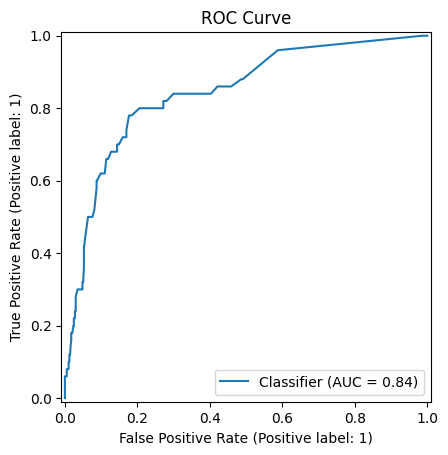

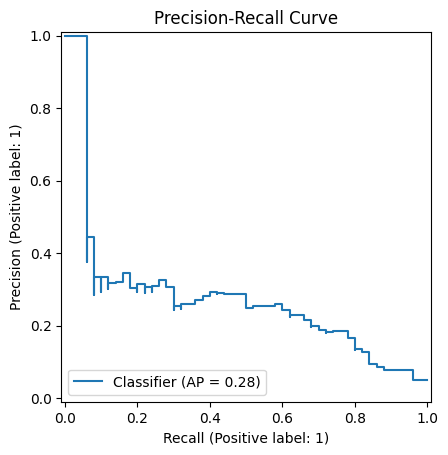

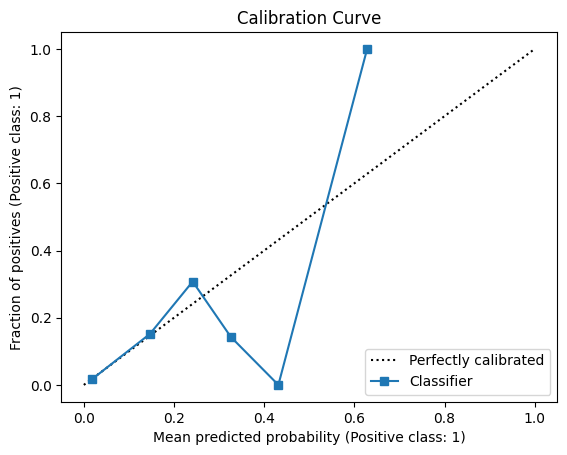

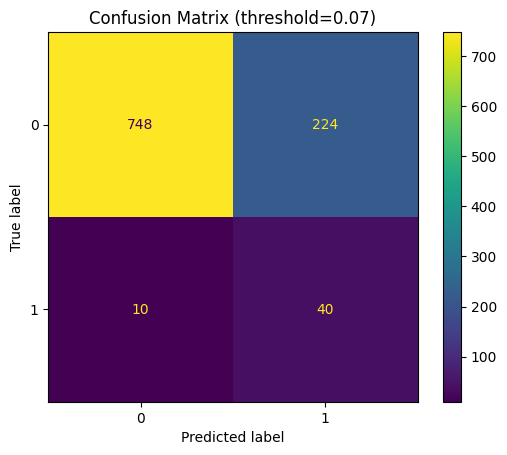

In [26]:
from pathlib import Path
from IPython.display import Image, display

figs = [
    "roc_curve.png",
    "pr_curve.png",
    "calibration_curve.png",
    "confusion_matrix.png",
]

for fn in figs:
    p = Path("reports/figures") / fn
    if p.exists():
        display(Image(filename=str(p)))
    else:
        print("Missing:", p)


## 6) Explainability
We generate:
- **SHAP** explanations via an interpretable *surrogate glass-box* model trained to mimic the ensemble.
- **LIME** local explanation directly on the real model.

> Note: Stacking models are complex; the surrogate makes feature-level clinical justification easier to communicate.

In [27]:
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from lime.lime_tabular import LimeTabularExplainer

# Transform into model feature space
pre = pipeline.named_steps["preprocess"]
X_t = pre.transform(X)
feature_names = pre.get_feature_names_out()

# Soft labels from the real ensemble
y_soft = pipeline.predict_proba(X)[:, 1]
y_bin = (y_soft >= 0.5).astype(int)

# Train an interpretable surrogate (logistic) on transformed features
surrogate = LogisticRegression(max_iter=6000, class_weight="balanced")
surrogate.fit(X_t, y_bin)
print("✅ Trained surrogate.")


c:\Users\Shahriar\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Trained surrogate.


c:\Users\Shahriar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
C:\TEMP\ipykernel_24680\1771111377.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=explain_X, feature_names=feature_names, show=True, max_display=20)


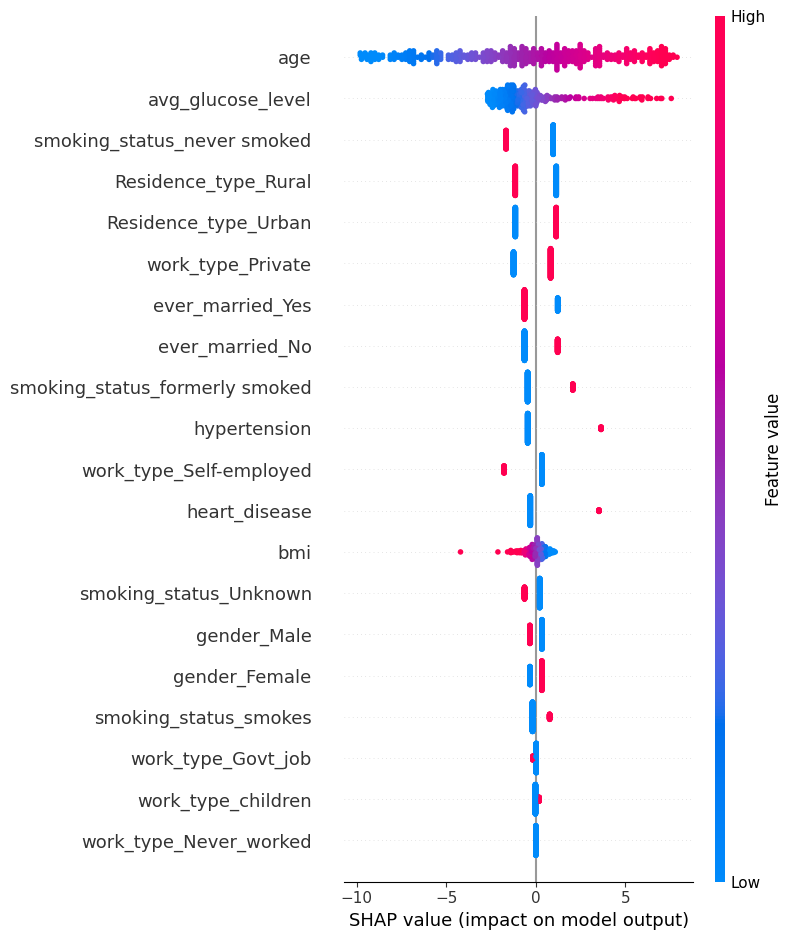

In [28]:
# SHAP (global)
bg_n = min(int(cfg["explain"]["background_samples"]), X_t.shape[0])
ex_n = min(int(cfg["explain"]["shap_samples"]), X_t.shape[0])

rng = np.random.default_rng(42)
bg_idx = rng.choice(X_t.shape[0], size=bg_n, replace=False)
ex_idx = rng.choice(X_t.shape[0], size=ex_n, replace=False)

background = X_t[bg_idx]
explain_X = X_t[ex_idx]

explainer = shap.LinearExplainer(surrogate, background, feature_perturbation="interventional")
shap_values = explainer(explain_X)

# Beeswarm
shap.summary_plot(shap_values, features=explain_X, feature_names=feature_names, show=True, max_display=20)


C:\TEMP\ipykernel_24680\636131569.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=explain_X, feature_names=feature_names, plot_type="bar", show=True, max_display=20)


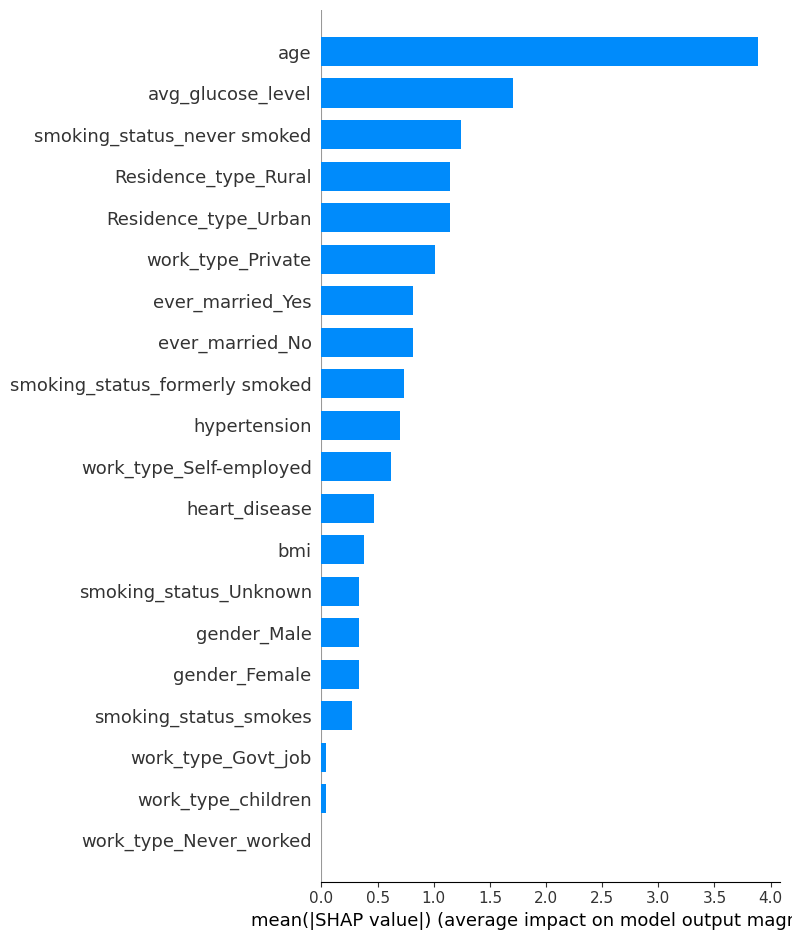

In [29]:
# Bar plot (global importance)
shap.summary_plot(shap_values, features=explain_X, feature_names=feature_names, plot_type="bar", show=True, max_display=20)


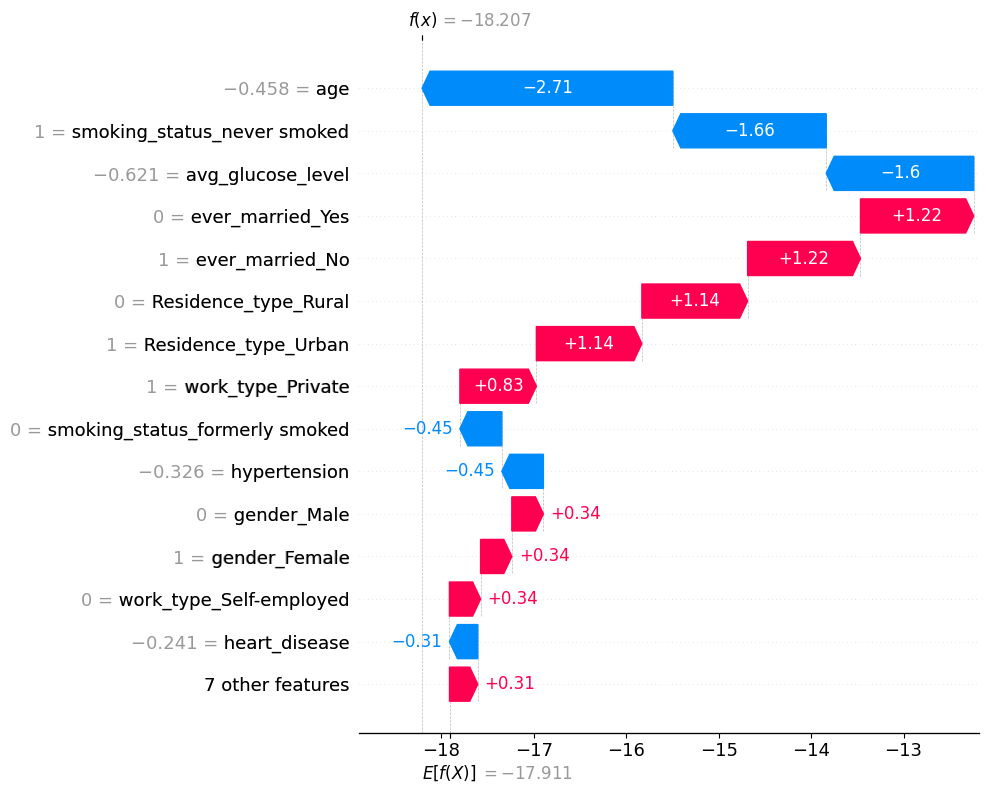

In [30]:
# Local explanation for one example patient
i = 0
exp = shap.Explanation(
    values=shap_values[i],
    base_values=explainer.expected_value,
    data=explain_X[i],
    feature_names=feature_names
)
shap.plots.waterfall(exp, max_display=15, show=True)


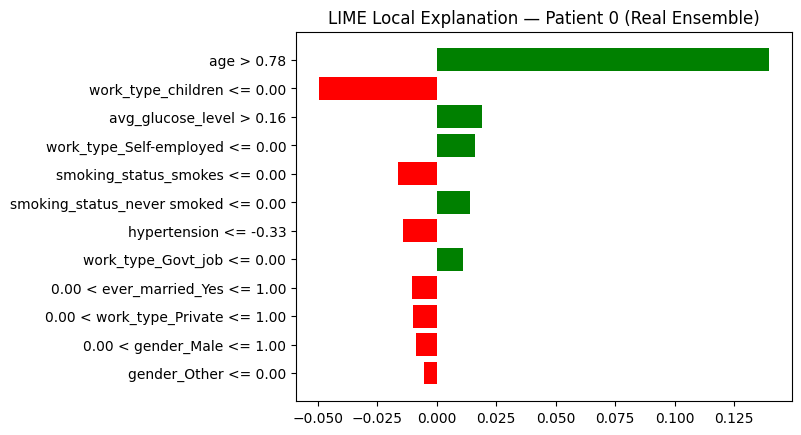

In [31]:
# LIME local explanation (real ensemble) on transformed space
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_t),
    feature_names=list(feature_names),
    class_names=["no_stroke", "stroke"],
    mode="classification"
)

real_model = pipeline.named_steps["model"]

def predict_proba_transformed(Xt):
    return real_model.predict_proba(Xt)

lime_exp = lime_explainer.explain_instance(
    data_row=np.array(X_t[0]),
    predict_fn=predict_proba_transformed,
    num_features=int(cfg["explain"]["lime_num_features"])
)

fig = lime_exp.as_pyplot_figure()
plt.title("LIME Local Explanation — Patient 0 (Real Ensemble)")
plt.show()


## Interpretation & Reporting Notes
- With the stroke dataset, **age** and **avg_glucose_level** often dominate SHAP importance, which is clinically consistent.
- Because the data is imbalanced, **PR-AUC** and **Recall** matter more than accuracy.
- Your recall-first threshold (e.g., `min_recall=0.75`) makes the system suitable for **screening-style decision support**.